<Axes: >

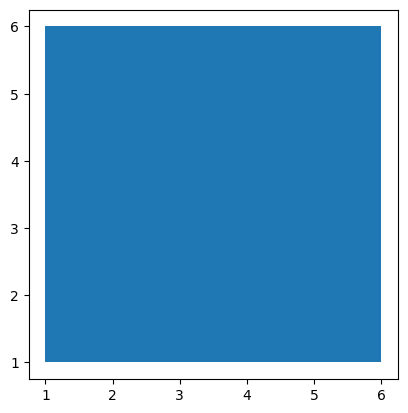

In [119]:
import numpy as np
import geopandas as gpd
from shapely.geometry import box

minx = 1
maxx = 5.1
grid_size = 1
x_bins = np.arange(minx, maxx + grid_size, grid_size)
y_bins = np.arange(minx, maxx + grid_size, grid_size)

# Create box geometries that covered all jx_poly_proj based on generated bins 
polygons = []
for i in range(len(y_bins)-1):
    for j in range(len(x_bins)-1):
        # create 5km * 5km grids
        poly = box(x_bins[j], y_bins[i], x_bins[j+1], y_bins[i+1])
        polygons.append({
            "cell_id": f"{i}_{j}", # use i_j here because y_bins are row numbers while x_bins are column numbers
            "geometry": poly,
            "cell_y": i,
            "cell_x": j
        })
jx_grid = gpd.GeoDataFrame(polygons, crs="EPSG:4527")
jx_grid.plot()


<Axes: >

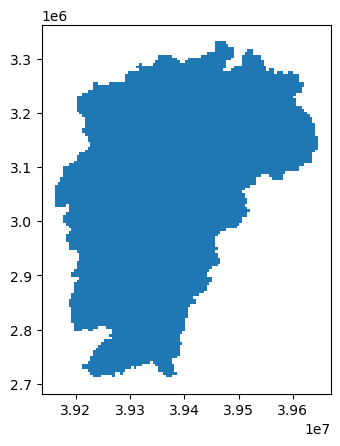

In [79]:
jx_grid.geometry.intersection(box(2,2,3,3)).area>0
data = gpd.read_file("jiangxi/jx_grid.gpkg")
data.plot()

In [ ]:
from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:32650", "EPSG:4326", always_xy=True)
a,b = transformer.transform(
     [9890339.891394898],[39503897.8622527]
)

from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32650", always_xy=True)
c,d = transformer.transform(
    [119],
    [89]
)

a,b,c,d

([inf], [inf], [39503897.8622527], [9890339.891394898])

In [ ]:
jx_poly = gpd.read_file('jiangxi/jiangxi_shape.shp').to_crs("EPSG:32650").area
# jx_poly = gpd.read_file('jiangxi/jiangxi_shape.shp')
# jx_poly.plot()
jx_poly

0    1.677230e+11
dtype: float64

In [123]:
jx_grid[jx_grid["cell_y"].isin(set([0,1]))]
set(jx_grid['cell_id'])

{'0_0',
 '0_1',
 '0_2',
 '0_3',
 '0_4',
 '1_0',
 '1_1',
 '1_2',
 '1_3',
 '1_4',
 '2_0',
 '2_1',
 '2_2',
 '2_3',
 '2_4',
 '3_0',
 '3_1',
 '3_2',
 '3_3',
 '3_4',
 '4_0',
 '4_1',
 '4_2',
 '4_3',
 '4_4'}

In [129]:
import pandas as pd

date_range = pd.date_range(start='2020-01-01', end='2020-01-03', freq='D')
dates_df = pd.DataFrame({'date': date_range})
dates_df['date']

dates_df2 = dates_df
dates_df['key'] = 1
dates_df2['key'] = 1
panel_df = pd.merge(dates_df, dates_df2, on='key').drop('key', axis=1)
panel_df

,date_x,date_y
0,2020-01-01,2020-01-01
1,2020-01-01,2020-01-02
2,2020-01-01,2020-01-03
3,2020-01-02,2020-01-01
4,2020-01-02,2020-01-02
5,2020-01-02,2020-01-03
6,2020-01-03,2020-01-01
7,2020-01-03,2020-01-02
8,2020-01-03,2020-01-03


In [130]:
# Author: Anora Wu
# Date: Jan 7th 2026
# Construct a panel data, with each day between 2020-2025 being the time variable and each grid being the identity. 
# Each identity has a geometry and a id. 
# Fill in the cloud seeding operation day and location into the time slots and the grid 

import geopandas as gpd
import pandas as pd
import numpy as np
import os
import warnings
from shapely.geometry import box
from pyproj import Transformer


# Change to your rawdata directory
os.chdir('/Users/anora/Team MG Dropbox/Wanru Wu/Cloudseeding_Anora')

### CONSTRUCT GRID ###

# Load and project JX polygon to EPSG:32650 
jx_poly = gpd.read_file('jiangxi/jiangxi_shape.shp').geometry.iloc[0]
# Original jx_poly was in "EPSG:4326", convert it to "EPSG:32650" to construct grids in kilometers
# "EPSG:32650" is used between between 114°E and 120°E
jx_poly_proj = gpd.GeoSeries([jx_poly], crs="EPSG:4326").to_crs("EPSG:32650").iloc[0]

# Calculate the bound of JX province            
minx, miny, maxx, maxy = jx_poly_proj.bounds              

# Bins for 5km grid
grid_size = 5000
# Create boundaries for grids
# The last bin created by np.arange will cover the maxx and maxy
x_bins = np.arange(minx, maxx + grid_size, grid_size)
y_bins = np.arange(miny, maxy + grid_size, grid_size)

# Create box geometries that covered all jx_poly_proj based on generated bins 
polygons = []
for i in range(len(y_bins)-1):
    for j in range(len(x_bins)-1):
        # create 5km * 5km grids
        poly = box(x_bins[j], y_bins[i], x_bins[j+1], y_bins[i+1])
        polygons.append({
            "cell_id": f"{i}_{j}", # use i_j here because y_bins are row numbers while x_bins are column numbers
            "geometry": poly,
            "cell_y": i,
            "cell_x": j
        })
jx_grid = gpd.GeoDataFrame(polygons, crs="EPSG:32650")

# Filtering out grids outside JX, only keeping grids whose area of intersection with JX is larger than 0
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning, message= "invalid value encountered in intersects")
    jx_grid = jx_grid[jx_grid.geometry.intersection(jx_poly_proj).area > 0]

# Save as GeoPackage 
jx_grid.to_file("jiangxi/jx_grid.gpkg", layer='grid', driver="GPKG")

# Save as CSV for later use
df = pd.DataFrame(jx_grid.drop(columns='geometry'))
df.to_csv("jiangxi/jx_grid.csv", index=False)


### FILL IN OPERATION DATA ###

operation_data = pd.read_csv('operation/cleaned_data.csv')

# Correct one mistake in the data
condition = (operation_data['date'] == "2022-10-27") & (operation_data['start_time'] == "09:42") & (operation_data['city_o'] == "九江市")
operation_data.loc[condition, 'lon'] = 115.56
operation_data.loc[condition, 'lat'] = 29.043

# Add year and day of year to operation data
operation_data['date'] = pd.to_datetime(operation_data['date'])
operation_data['day'] = operation_data['date'].dt.dayofyear
operation_data['year'] = operation_data['date'].dt.year

# Transfer lat and lon to EPSG:32650
# "always_xy=True" ensures using the traditional GIS order, 
# that is longitude, latitude for EPSG:4326 and easting, northing for EPSG:32650
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32650", always_xy=True)
operation_data['xs'], operation_data['ys'] = transformer.transform(
    operation_data['lon'].values, 
    operation_data['lat'].values
)

# Get cell_x and cell_y, which starts from 0 (rather than 1)
operation_data['cell_x'] = (np.array(operation_data['xs'])-minx)//grid_size 
operation_data['cell_y'] = (np.array(operation_data['ys'])-miny)//grid_size 

# Generate cell_id of the cell each operation data is in
operation_data['cell_id'] = (
    operation_data['cell_y'].astype(int).astype(str) + "_" + 
    operation_data['cell_x'].astype(int).astype(str)
)

# Filtering out invalid entries (operation outside JX)
valid_cells = set(jx_grid['cell_id'])
operation_data = operation_data[operation_data['cell_id'].isin(valid_cells)]

# Construct panel
date_range = pd.date_range(start='2020-01-01', end='2025-12-31', freq='D')
dates_df = pd.DataFrame({'date': date_range})
dates_df['year'] = dates_df['date'].dt.year
dates_df['month'] = dates_df['date'].dt.month
dates_df['day'] = dates_df['date'].dt.day

grid_ids = jx_grid[['cell_id']].copy()
dates_df['key'] = 1
grid_ids['key'] = 1
panel_df = pd.merge(dates_df, grid_ids, on='key').drop('key', axis=1)

# Count operation times
op_counts = operation_data.groupby(['date', 'cell_id'])
op_counts

/opt/anaconda3/envs/cloudseeding/lib/python3.9/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


In [ ]:
a = op_counts.size().reset_index().rename({"0":"count"})
a

,date,cell_id,0
0,2020-01-07,115_46,1
1,2020-01-07,27_27,1
2,2020-01-07,41_15,1
3,2020-01-07,43_22,1
4,2020-01-07,43_33,1
...,...,...,...
8621,2025-10-21,57_32,1
8622,2025-10-21,58_30,1
8623,2025-10-21,68_13,1
8624,2025-10-21,93_41,1
